# RSNA ICH baseline model(resnet18) shap explanation

## Resource
1. [RSNA-ICH chanllenge](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection)
2. [Fastai notebook](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109649)
3. [shap notebook](https://github.com/slundberg/shap/blob/master/notebooks/gradient_explainer/)

## import package

In [47]:
# if you haven't downloaded shap package
!conda install -c conda-forge shap --yes

Solving environment: done

## Package Plan ##

  environment location: /home/yihsin/anaconda3

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.2                |           py37_0         3.0 MB  conda-forge
    shap-0.34.0                |   py37hb3f55d8_0         377 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.4 MB

The following NEW packages will be INSTALLED:

  shap               conda-forge/linux-64::shap-0.34.0-py37hb3f55d8_0

The following packages will be SUPERSEDED by a higher-priority channel:

  conda                                           pkgs/main --> conda-forge



shap-0.34.0          | 377 KB    | ##################################### | 100% 
conda-4.8.2          | 3.0 MB    | ##################################### | 100% 
Prep

In [1]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

1.4.0
True
True


In [2]:
!nvidia-smi

Sun Feb 16 19:56:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
| 26%   29C    P8     2W / 260W |   4393MiB / 11016MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
import pandas as pd

## Import dataframe containing image file name and label

In [4]:
df = pd.read_csv('../csv/train_labels_as_strings_all.csv')
df.head()

,fn,labels
0,ID_12cadc6af.png,NaN
1,ID_38fd7baa0.png,NaN
2,ID_6c5d82413.png,NaN
3,ID_aec8e68b3.png,subarachnoid any
4,ID_4d9209c7c.png,NaN


In [5]:
df.labels.fillna('', inplace=True)
df.head()

,fn,labels
0,ID_12cadc6af.png,
1,ID_38fd7baa0.png,
2,ID_6c5d82413.png,
3,ID_aec8e68b3.png,subarachnoid any
4,ID_4d9209c7c.png,


## Data

In [6]:
path=Path('../output224/stage_2_train')

In [7]:
'''
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src.transform(tfms, size=256)
        .databunch(bs=16).normalize(imagenet_stats))
learn.data = data
'''
from fastai.data_block import _maybe_squeeze
def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)

In [8]:
ItemList.label_from_df = modified_label_from_df

In [9]:
np.random.seed(42) # set random seed so we always get the same validation set
data = (ImageList.from_df(df,path)
       # Load data from csv
       .random_split_by_pct(0.2)
       # split data into training and validation set (20% validation)
       .label_from_df(label_delim=' ')
       # label data using the tags column (second column is default)
       .databunch(bs=32)
       )

/home/yihsin/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:215: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [10]:
len(data.train_dl)

18820

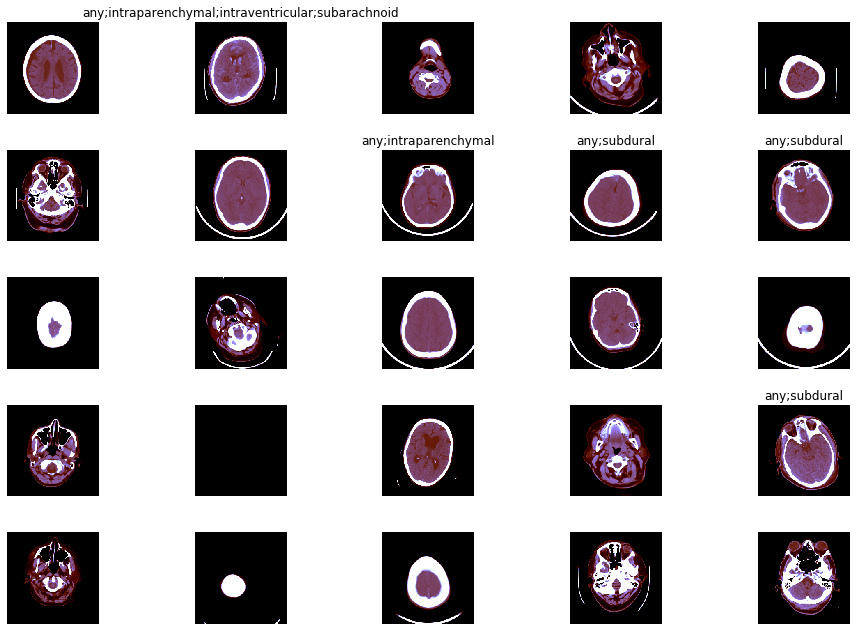

In [11]:
data.show_batch(rows=5, figsize=(12, 9))

## Create and train baseline model

In [12]:
print(torch.cuda.is_available(),  torch.backends.cudnn.enabled)
torch.cuda.current_device() 

True True


0

In [13]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy_thresh])

epoch,train_loss,valid_loss,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-07
Min loss divided by 10: 6.67E-03


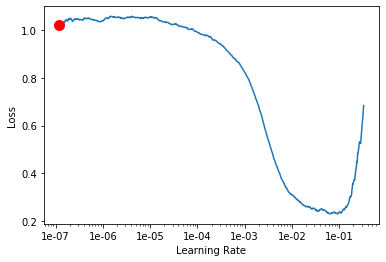

In [19]:
#learn.lr_find()
learn.lr_find(num_it=1000)
learn.recorder.plot(suggestion=True)

In [21]:
learn.fit_one_cycle(5,max_lr=slice(5.0E-05 , 5.0E-03),pct_start=0.8,
                   callbacks=[SaveModelCallback(learn, every='improvement',monitor='valid_loss'
                                                ,name='model_RSNA_ICH_resnet18_win')])

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.126572,0.125592,0.954633,10:08
1,0.115921,0.114207,0.958237,10:01
2,0.109520,0.108166,0.960917,10:00
3,0.109631,0.104870,0.962567,09:58
4,0.096890,0.097507,0.964834,09:58


Better model found at epoch 0 with valid_loss value: 0.12559206783771515.
Better model found at epoch 1 with valid_loss value: 0.11420654505491257.
Better model found at epoch 2 with valid_loss value: 0.10816595703363419.
Better model found at epoch 3 with valid_loss value: 0.10486999899148941.
Better model found at epoch 4 with valid_loss value: 0.09750718623399734.


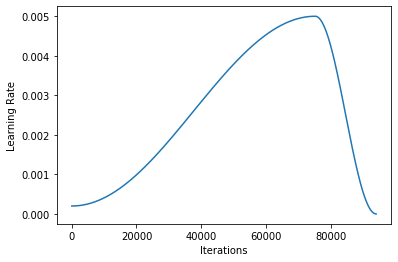

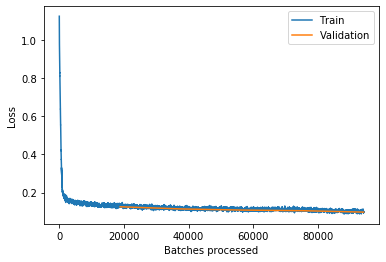

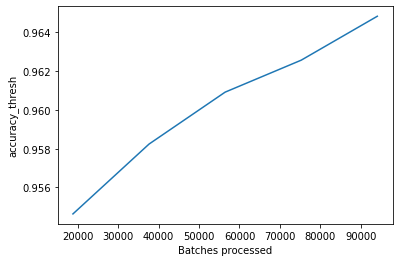

In [22]:
learn.recorder.plot_lr()
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

## load model

In [14]:
# load trained model
learn.load('model_RSNA_ICH_resnet18_win')
#learn.unfreeze()

Learner(data=ImageDataBunch;

Train: LabelList (602243 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
,,subarachnoid;any,,
Path: ../output224/stage_2_train;

Valid: LabelList (150560 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
,,,,intraparenchymal;intraventricular;any
Path: ../output224/stage_2_train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

## Build shap explanation

In [15]:
import shap

### check model architecture and choose which layer to be explaned

In [16]:
# check model architecture and choose which layer to be explaned
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [20]:
learn.model._modules.get('0')[5][1]

BasicBlock(
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [21]:
# the layer format we want
learn.model._modules.get('0')[5][1]._modules['conv1']

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

### Choose two images to explain

In [22]:
### check classes
class_names=data.y.classes
class_names

['any',
 'epidural',
 'intraparenchymal',
 'intraventricular',
 'subarachnoid',
 'subdural']

file name: ../output224/stage_2_train/ID_cf09cd30d.png
label: ['subdural', 'any']


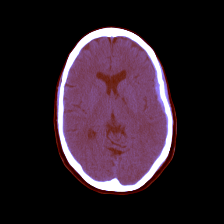

In [23]:
print('file name:',data.valid_ds.x.items[34])
print('label:',[class_names[i] for i in data.valid_ds.y.items[34]])
data.valid_ds.x[34]

file name: ../output224/stage_2_train/ID_07c0ebde0.png
label: ['subarachnoid', 'any']


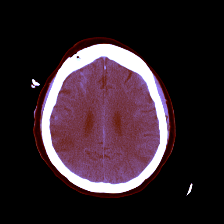

In [24]:
print('file name:',data.valid_ds.x.items[44])
print('label:',[class_names[i] for i in data.valid_ds.y.items[44]])
data.valid_ds.x[44]

In [25]:
# 34
to_explain1=pil2tensor(PIL.Image.open('../output224/stage_2_train/ID_cf09cd30d.png'), np.float32).div_(255).unsqueeze(0)
print(to_explain1.shape)
# 44
to_explain2=pil2tensor(PIL.Image.open('../output224/stage_2_train/ID_07c0ebde0.png'), np.float32).div_(255).unsqueeze(0)
print(to_explain2.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [26]:
to_explains= torch.cat((to_explain1,to_explain2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
to_explains=to_explains.to(device)
print(to_explains.shape)

torch.Size([2, 3, 224, 224])


### Produce and plot shap explanation

In [27]:
model=learn.model.eval()

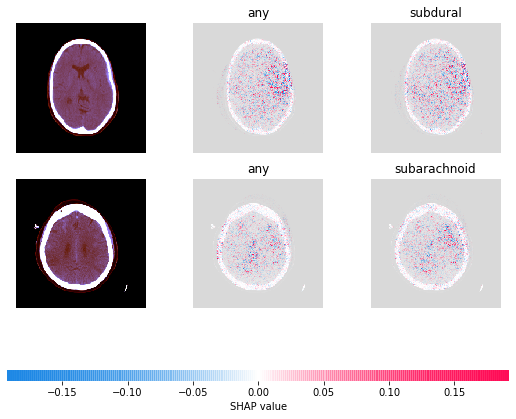

In [30]:
#choose which layer to be explained
layer=learn.model._modules.get('0')[0]
# produce shap explanation
e = shap.GradientExplainer((model, layer), to_explains)
shap_values,indexes = e.shap_values(to_explains, ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu().numpy())

# plot
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, np.swapaxes(np.swapaxes(to_explains.cpu().numpy(),1,3),1,2), index_names)

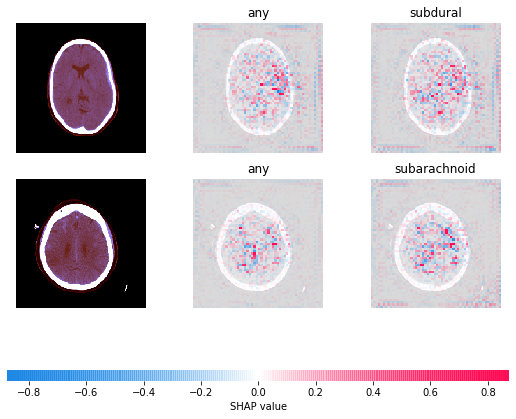

In [31]:
#choose which layer to be explained
layer=learn.model._modules.get('0')[4][0]._modules['conv1']

# produce shap explanation
e = shap.GradientExplainer((model, layer), to_explains)
shap_values,indexes = e.shap_values(to_explains, ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu().numpy())

# plot
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, np.swapaxes(np.swapaxes(to_explains.cpu().numpy(),1,3),1,2), index_names)

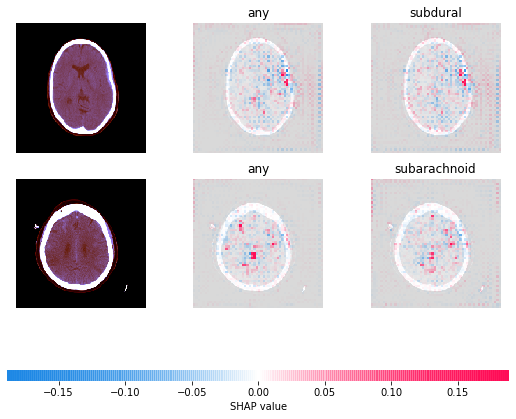

In [29]:
#choose which layer to be explained
layer=learn.model._modules.get('0')[5][0]._modules['conv1']

# produce shap explanation
e = shap.GradientExplainer((model, layer), to_explains)
shap_values,indexes = e.shap_values(to_explains, ranked_outputs=2, nsamples=200)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[x])(indexes.cpu().numpy())

# plot
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, np.swapaxes(np.swapaxes(to_explains.cpu().numpy(),1,3),1,2), index_names)

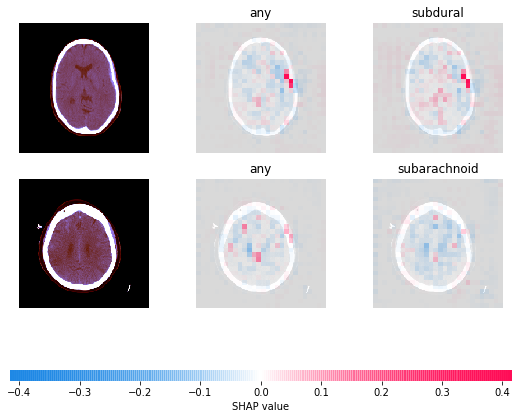

In [32]:
layer=learn.model._modules.get('0')[6][0]._modules['conv1']

e = shap.GradientExplainer((model, layer), to_explains)
shap_values,indexes = e.shap_values(to_explains, ranked_outputs=2, nsamples=200)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, np.swapaxes(np.swapaxes(to_explains.cpu().numpy(),1,3),1,2), index_names)

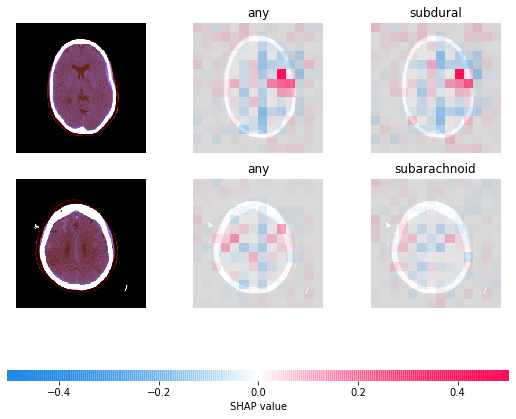

In [33]:
layer=learn.model._modules.get('0')[7][0]._modules['conv1']

e = shap.GradientExplainer((model, layer), to_explains)
shap_values,indexes = e.shap_values(to_explains, ranked_outputs=2, nsamples=200)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]
shap.image_plot(shap_values, np.swapaxes(np.swapaxes(to_explains.cpu().numpy(),1,3),1,2), index_names)

### The prediction of 34 and 44 images

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

In [35]:
class_names

['any',
 'epidural',
 'intraparenchymal',
 'intraventricular',
 'subarachnoid',
 'subdural']

In [36]:
(interp.preds)[34]

tensor([0.8260, 0.0246, 0.0094, 0.0024, 0.0565, 0.8138])

In [37]:
(interp.preds)[44]

tensor([0.8274, 0.0028, 0.3039, 0.3248, 0.6252, 0.0789])